# Converting NumPy arrays into gridfiles for GMT and netCDF4
- Simple function to write either a native Generic Mapping Tools (GMT) gridfile or a netCDF-compatible 

In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import struct
from netCDF4 import Dataset

Generate a simple array of random numbers to save

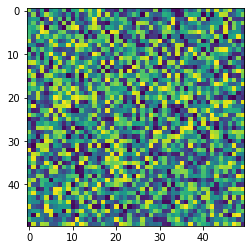

In [2]:
noise = np.random.random((50,50))
plt.imshow(noise)

Save array as either type of grid file

In [3]:
def array_to_grd(filename,
                 array, 
                 x_vals=None,y_vals=None, #data
                 x_name=None,y_name=None, #labels
                 bin_mask=False, # integer 1-0 mask at pixels
                 netcdf_write=False, # write standard NetCDF grid
                 native_gmt=False, # write native GMT binary
                 slice_array=False, spacing=2, # subsample options
                 xunits = 'x [unitless]', #x-data name
                 yunits = 'y [unitless]', #z-data name
                 zunits = 'z [unitless]', #z-data name
                 title = 'arbitrary data',
                 cmd = 'Generated by a custom Python function',
                 remark = 'None'):
    '''
    Write 2D array to a COORDS-compliant NETCDF4 .grd file, 
        compatible with GMT. Useful to make binary (0-1) masks to multiply 
        against GMT-generated .grd files.
    Allows for every [spacing]-th point to be sampled, useful for decreasing
        filesize if all elements of array aren't needed.
    Assumes and image-like coordinate system, where each (x,y) coordinate
        is a pixel, unless exact (x,y) coordinates are given [x_vals,y_vals].
    Allows for a GMT-native .grd file to be written with custom dimension and
        field names, or a modern netCDF4 HDF5 file to be created.
    
    Partially modified from:
        https://github.com/usgs/MapIO/blob/master/mapio/gmt.py
    
    TODO: 
        - figure out array convention for correct plotting direction in GMT
    '''
    # subsample array, every [spacing] points
    if x_vals is None or y_vals is None:
        if slice_array:
            xcoords = range(array.shape[1])[::spacing]
            ycoords = range(array.shape[0])[::spacing]
            array = array[::spacing,::spacing]
        else:
            xcoords = range(array.shape[1])
            ycoords = range(array.shape[0])      
    else:
        if slice_array:
            xcoords = x_vals[::spacing]
            ycoords = y_vals[::spacing]
            array = array[::spacing,::spacing]
        else:
            xcoords = x_vals
            ycoords = y_vals   
    if netcdf_write:
        # create and open netcdf file
        gmt_file = Dataset(filename, 'w', format='NETCDF4')
        # if no alternative dimension names given, set default
        if not x_name or not y_name:
            x_name='x'
            y_name='y'
        # dimensions of file, with an unspecified shape for z
        gmt_file.createDimension(x_name, array.shape[1])
        gmt_file.createDimension(y_name, array.shape[0])
        gmt_file.createDimension('z', None)
        # variables, with predefined dimensions, according to swapped default GMT 
        #   name conventions for "x" and "y" dimensions
        if bin_mask: #integer ones-and-zeros, at each pixel
            X = gmt_file.createVariable(x_name, 'i4', (x_name,))
            Y = gmt_file.createVariable(y_name, 'i4', (y_name,))
            Z = gmt_file.createVariable('z', 'i1', (y_name, x_name))
        else: #simple 32-bit float
            X = gmt_file.createVariable(x_name, 'f', (x_name,))
            Y = gmt_file.createVariable(y_name, 'f', (y_name,))
            Z = gmt_file.createVariable('z',  'f', (y_name, x_name))
            xcoords = np.float32(xcoords)
            ycoords = np.float32(ycoords)
            array = np.float32(array)
        # data, with x and y pixel locations, and the array with min and max
        X[:] = xcoords
        Y[:] = ycoords
        Z[:,:] = array
        Z.actual_range = np.array((np.nanmin(array),np.nanmax(array)))
        # close file
        gmt_file.close()
    # GMT-native format, with custom labels
    # see GMT API documentation:
    #    http://gmt.soest.hawaii.edu/doc/5.4.2/GMT_API.html#gmt-grids
    elif native_gmt: 
        gmt_file = open(filename,'wb')
        gmt_file.write(struct.pack('I',array.shape[1])) #ncols
        gmt_file.write(struct.pack('I',array.shape[0])) #nrows
        gmt_file.write(struct.pack('I',0)) #node offset, 0=gridline, 1=pixel
        gmt_file.write(struct.pack('d',np.nanmin(xcoords))) #x-min
        gmt_file.write(struct.pack('d',np.nanmax(xcoords))) #y-min
        gmt_file.write(struct.pack('d',np.nanmin(ycoords))) #y-min
        gmt_file.write(struct.pack('d',np.nanmax(ycoords))) #y-max
        gmt_file.write(struct.pack('d',np.nanmin(array))) #z-min
        gmt_file.write(struct.pack('d',np.nanmax(array))) #z-max
        gmt_file.write(struct.pack('d',np.diff(xcoords).mean())) #dx
        gmt_file.write(struct.pack('d',np.diff(ycoords).mean())) #dy
        gmt_file.write(struct.pack('d',1)) #z scale factor
        gmt_file.write(struct.pack('d',0)) #z offset
        # LABELS, cropped to max char length for required GMT header format
        xpad = [0 for i in range(0,80-len(xunits))]
        ypad = [0 for i in range(0,80-len(yunits))]
        zpad = [0 for i in range(0,80-len(zunits))]
        tpad = [0 for i in range(0,80-len(title))]
        cpad = [0 for i in range(0,320-len(cmd))]
        rpad = [0 for i in range(0,160-len(remark))]
        xfmt = '%ib' % (80-len(xunits))
        yfmt = '%ib' % (80-len(yunits))
        zfmt = '%ib' % (80-len(zunits))
        tfmt = '%ib' % (80-len(title))
        cfmt = '%ib' % (320-len(cmd))
        rfmt = '%ib' % (160-len(remark))
        gmt_file.write(xunits.encode()) 
        gmt_file.write(struct.pack(xfmt,*xpad))
        gmt_file.write(yunits.encode())
        gmt_file.write(struct.pack(yfmt,*ypad))
        gmt_file.write(zunits.encode())
        gmt_file.write(struct.pack(zfmt,*zpad))
        gmt_file.write(title.encode())
        gmt_file.write(struct.pack(tfmt,*tpad))
        gmt_file.write(cmd.encode())
        gmt_file.write(struct.pack(cfmt,*cpad))
        gmt_file.write(remark.encode())
        gmt_file.write(struct.pack(rfmt,*rpad))
        nrows,ncols = array.shape
        sfmt = '%i%s' % (nrows*ncols,array.dtype.kind)
        # write data after flipping, due to how data is written to file and
        #   read by GMT as a column of data
        gmt_file.write(struct.pack(sfmt,*np.flipud(array).flatten()))
        gmt_file.close()
    else:
        raise Exception('Please specify method of gridfile creation.')

# Save, load and plot native GMT .grd file

In [4]:
array_to_grd('test.grd',noise,native_gmt=True)

Use the following command in GMT 6 to make a quick plot of the array.

```gmt grdimage test.grd -JX1i+ -I+ -png noise```

![](noise.png)

# Save, load, and plot a netCDF4 file

In [5]:
array_to_grd('test.nc',noise,netcdf_write=True)

In [6]:
import netCDF4
data = netCDF4.Dataset('test.nc')

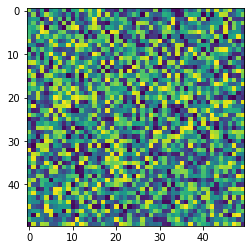

In [7]:
noise_retrieved = data['z'][:]
plt.imshow(noise_retrieved)